In [ ]:
from sklearn.datasets import fetch_openml

In [ ]:
import numpy as np

In [ ]:
import sklearn.datasets
x=sklearn.datasets.fetch_openml("mnist_784")

In [ ]:
X, Y = x['data'], x['target']
X_array = X.to_numpy()
Y_array = Y.astype(np.uint8).to_numpy()
X_train, X_test = X_array[:60000], X_array[60000:]  # Первые 60000 объектов для обучения, остальные для тестирования
Y_train, Y_test = Y_array[:60000], Y_array[60000:]  # Соответствующие метки

# Вывод информации о размерах массивов
print("Форма обучающей выборки (X_train):", X_train.shape)
print("Форма тестовой выборки (X_test):", X_test.shape)
print("Форма меток обучающей выборки (y_train):", Y_train.shape)
print("Форма меток тестовой выборки (y_test):", Y_test.shape)

Форма обучающей выборки (X_train): (60000, 784)
Форма тестовой выборки (X_test): (10000, 784)
Форма меток обучающей выборки (y_train): (60000,)
Форма меток тестовой выборки (y_test): (10000,)


In [ ]:
X_train, X_test = X_array[:10000], X_array[69900:]  # Первые 60000 объектов для обучения, остальные для тестирования
Y_train, Y_test = Y_array[:10000], Y_array[69900:]  # Соответствующие метки
print("Форма обучающей выборки (X_train):", X_train.shape)
print("Форма тестовой выборки (X_test):", X_test.shape)
print("Форма меток обучающей выборки (y_train):", Y_train.shape)
print("Форма меток тестовой выборки (y_test):", Y_test.shape)

Форма обучающей выборки (X_train): (10000, 784)
Форма тестовой выборки (X_test): (100, 784)
Форма меток обучающей выборки (y_train): (10000,)
Форма меток тестовой выборки (y_test): (100,)


In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

Классификатор

In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors


def euclidean_distance(X, Y):
    X_s = np.sum(X ** 2, axis=1)[:, np.newaxis]
    Y_s = np.sum(Y ** 2, axis=1)[np.newaxis, :]
    t = X_s + Y_s - 2 * np.dot(X, Y.T)
    t = np.maximum(t, 0)
    return np.sqrt(t)


def cosine_distance(X, Y):
    a = np.linalg.norm(X, axis=1)[:, np.newaxis]
    b = np.linalg.norm(Y, axis=1)[np.newaxis, :]
    a[a == 0] = 1
    b[b == 0] = 1
    return 1 - (np.dot(X, Y.T) / (a * b))


class KNNClassifier:
    def __init__(self, k=2, strategy='kd_tree', metric='euclidean', weights='False', test_block_size=5000):
        self.k = k
        self.strategy = strategy
        self.metric = metric
        self.weights = weights
        self.test_block_size = test_block_size
        if strategy != 'my_own':
            self.model = NearestNeighbors(n_neighbors=k, algorithm=strategy, metric=metric)
        else:
            pass

    def fit(self, X, y):
        self.y_train = y
        if self.strategy != 'my_own':
            self.model.fit(X)
        else:
            self.X_train = X

    def find_kneighbors(self, X, return_distance=False):
        num_samples = X.shape[0]
        indices = np.array([], dtype=np.int64).reshape((0, self.k))
        dists = np.array([], dtype=np.float64).reshape((0, self.k))
        for start_idx in range(0, num_samples, self.test_block_size):
            end_idx = min(start_idx + self.test_block_size, num_samples)
            X_block = X[start_idx:end_idx]
            if self.strategy != 'my_own':
                block_dists, block_indices = self.model.kneighbors(X_block)
            else:
                if self.metric == 'euclidean':
                    distan = euclidean_distance(X_block, self.X_train)
                else:
                    distan = cosine_distance(X_block, self.X_train)
                block_indices = np.argsort(distan, axis=1)[:, :self.k]
                if return_distance:
                    block_dists = np.take_along_axis(distan, block_indices, axis=1)
            indices = np.vstack((indices, block_indices))
            if return_distance:
                dists = np.vstack((dists, block_dists))
        if return_distance:
            return dists, indices
        else:
            return indices

    def predict(self, X):
        if self.weights is True:
            dists, indices = self.find_kneighbors(X, True)
            weight = np.array([1.0 / (x + 0.00001) for x in dists])
            answer = []
            for i in range(len(indices)):
                answer.append(np.argmax(np.bincount(self.y_train[indices[i]], weights=weight[i])))
            return answer
        else:
            answer = []
            indices = self.find_kneighbors(X, False)
            for i in range(len(indices)):
                answer.append(np.argmax(np.bincount(self.y_train[indices[i]])))
            return answer


Валидация

In [ ]:
import numpy as np

np.int = int


def kfold(n, n_folds):
    indices = np.arange(n)
    fold_sizes = np.full(n_folds, n // n_folds, dtype=int)
    fold_sizes[:n % n_folds] += 1
    current = 0
    folds = []

    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        val_indices = indices[start:stop]
        train_indices = np.concatenate([indices[:start], indices[stop:]])
        folds.append((train_indices, val_indices))
        current = stop

    return folds


def knn_cross_val_score(X, y, k_list, score='accuracy', cv=None, **kwargs):
    if cv is None:
        n = X.shape[0]
        n_folds = 5
        cv = kfold(n, n_folds)
    scores_dict = {k: [] for k in k_list}
    for k in k_list:
        knn = KNNClassifier(k, **kwargs)
        for (train_indices, val_indices) in cv:
            X_train, X_val = X[train_indices], X[val_indices]
            y_train, y_val = y[train_indices], y[val_indices]
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_val)
            fold_score = calculate_accuracy(y_val, y_pred)
            scores_dict[k].append(fold_score)
    for k in scores_dict:
        scores_dict[k] = np.array(scores_dict[k])
    return scores_dict


def calculate_accuracy(pred, real):
    return np.mean(np.array(pred) == np.array(real))


1 эксперимент

In [ ]:
import time
def measure_time(knn, X_test):
    start_time = time.time()
    knn.find_kneighbors(X_test, return_distance=True)
    return time.time() - start_time
algorithms = ['kd_tree', 'ball_tree', 'brute', 'my_own']
subsets = [10, 20, 100]
results = {}
for subset in subsets:
    random_indices = np.random.choice(X_train.shape[1], subset, replace=False)
    X_train_subset = X_train[:, random_indices]
    X_test_subset = X_test[:, random_indices]
    for algo in algorithms:
        knn = KNNClassifier(k=5, strategy=algo, metric='euclidean')
        knn.fit(X_train_subset, Y_train)

        elapsed_time = measure_time(knn, X_test_subset)

        results[(subset, algo)] = elapsed_time
        print(f'Время для {algo} с {subset} признаками: {elapsed_time:.4f} секунд')
print("\nРезультаты:")
for key, value in results.items():
    print(f'Подмножество {key[0]}, Алгоритм {key[1]}: {value:.4f} секунд')

Время для kd_tree с 10 признаками: 1.9605 секунд
Время для ball_tree с 10 признаками: 6.5610 секунд
Время для brute с 10 признаками: 12.7770 секунд
Время для my_own с 10 признаками: 70.6859 секунд
Время для kd_tree с 20 признаками: 4.1876 секунд
Время для ball_tree с 20 признаками: 13.7012 секунд
Время для brute с 20 признаками: 13.2653 секунд
Время для my_own с 20 признаками: 78.0436 секунд
Время для kd_tree с 100 признаками: 142.2037 секунд
Время для ball_tree с 100 признаками: 129.5774 секунд
Время для brute с 100 признаками: 16.5912 секунд
Время для my_own с 100 признаками: 201.8345 секунд

Результаты:
Подмножество 10, Алгоритм kd_tree: 1.9605 секунд
Подмножество 10, Алгоритм ball_tree: 6.5610 секунд
Подмножество 10, Алгоритм brute: 12.7770 секунд
Подмножество 10, Алгоритм my_own: 70.6859 секунд
Подмножество 20, Алгоритм kd_tree: 4.1876 секунд
Подмножество 20, Алгоритм ball_tree: 13.7012 секунд
Подмножество 20, Алгоритм brute: 13.2653 секунд
Подмножество 20, Алгоритм my_own: 78.043

2 эксперимент

In [ ]:
def evaluate_knn(k_values, metrics, X_train, Y_train, n_folds=3):
    results = {}
    cv = kfold(len(Y_train), n_folds)
    for metric in metrics:
        for k in k_values:
            print(k)
            start_time = time.time()
            scores = knn_cross_val_score(X_train, Y_train, [k], score='accuracy', cv=cv, strategy='brute', metric=metric)
            elapsed_time = time.time() - start_time
            accuracy = np.mean(scores[k])
            results[(k, metric)] = {
                'accuracy': accuracy,
                'time': elapsed_time
            }

    return results

k_values = np.arange(1,11)
metrics = ['euclidean', 'cosine']

results = evaluate_knn(k_values, metrics, X_train, Y_train)

print("\nРезультаты кросс-валидации:")
for (k, metric), result in results.items():
    print(f'k={k}, Метрика={metric}: Точность={result["accuracy"]:.4f}, Время={result["time"]:.4f} секунд')

1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10

Результаты кросс-валидации:
k=1, Метрика=euclidean: Точность=0.9675, Время=141.7539 секунд
k=2, Метрика=euclidean: Точность=0.9605, Время=148.6679 секунд
k=3, Метрика=euclidean: Точность=0.9683, Время=152.4421 секунд
k=4, Метрика=euclidean: Точность=0.9669, Время=162.0717 секунд
k=5, Метрика=euclidean: Точность=0.9675, Время=159.7946 секунд
k=6, Метрика=euclidean: Точность=0.9654, Время=158.3275 секунд
k=7, Метрика=euclidean: Точность=0.9653, Время=162.1576 секунд
k=8, Метрика=euclidean: Точность=0.9644, Время=159.3670 секунд
k=9, Метрика=euclidean: Точность=0.9638, Время=158.4325 секунд
k=10, Метрика=euclidean: Точность=0.9628, Время=159.3755 секунд
k=1, Метрика=cosine: Точность=0.9715, Время=142.6465 секунд
k=2, Метрика=cosine: Точность=0.9677, Время=151.2978 секунд
k=3, Метрика=cosine: Точность=0.9720, Время=158.6533 секунд
k=4, Метрика=cosine: Точность=0.9719, Время=162.3024 секунд
k=5, Метрика=cosine: Точность=0.9715, Время=158.4214 секун

косинусная метрика лучше, с соседями лучше всего 3

In [ ]:
cv = kfold(len(Y_train), 3)

In [ ]:
X_train, X_test = X_array[:60000], X_array[60000:]
Y_train, Y_test = Y_array[:60000], Y_array[60000:]
print("Форма обучающей выборки (X_train):", X_train.shape)
print("Форма тестовой выборки (X_test):", X_test.shape)
print("Форма меток обучающей выборки (y_train):", Y_train.shape)
print("Форма меток тестовой выборки (y_test):", Y_test.shape)

Форма обучающей выборки (X_train): (60000, 784)
Форма тестовой выборки (X_test): (10000, 784)
Форма меток обучающей выборки (y_train): (60000,)
Форма меток тестовой выборки (y_test): (10000,)


In [ ]:
X_train, X_test = X_array[:1000], X_array[69000:]
Y_train, Y_test = Y_array[:1000], Y_array[69000:]
print("Форма обучающей выборки (X_train):", X_train.shape)
print("Форма тестовой выборки (X_test):", X_test.shape)
print("Форма меток обучающей выборки (y_train):", Y_train.shape)
print("Форма меток тестовой выборки (y_test):", Y_test.shape)

Форма обучающей выборки (X_train): (1000, 784)
Форма тестовой выборки (X_test): (1000, 784)
Форма меток обучающей выборки (y_train): (1000,)
Форма меток тестовой выборки (y_test): (1000,)


3 эксперимент

In [ ]:
import time
results = {}
cv = kfold(len(Y_train), 3)

for metric in ['euclidean', 'cosine']:
    for k in range(1,11):
        print(k)
        start_time = time.time()
        scores_weighted = knn_cross_val_score(X_train, Y_train, [k], score='accuracy', cv=cv, strategy='brute', metric=metric, weights=True)
        elapsed_time_weighted = time.time() - start_time
        accuracy_weighted = np.mean(scores_weighted[k])
        results[(k, metric)] = {
            'accuracy_weighted': accuracy_weighted,
            'time_weighted': elapsed_time_weighted}

print("\nРезультаты сравнения взвешенного и невзвешенного KNN:")
for (k, metric), result in results.items():
    print(f'k={k}, Метрика={metric}:'
          f'С весами - Точность={result["accuracy_weighted"]:.4f}, Время={result["time_weighted"]:.4f} секунд')

1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10

Результаты сравнения взвешенного и невзвешенного KNN:
k=1, Метрика=euclidean:С весами - Точность=0.9675, Время=146.3173 секунд
k=2, Метрика=euclidean:С весами - Точность=0.9675, Время=170.8075 секунд
k=3, Метрика=euclidean:С весами - Точность=0.9694, Время=166.8325 секунд
k=4, Метрика=euclidean:С весами - Точность=0.9704, Время=164.9805 секунд
k=5, Метрика=euclidean:С весами - Точность=0.9688, Время=161.0591 секунд
k=6, Метрика=euclidean:С весами - Точность=0.9694, Время=161.4557 секунд
k=7, Метрика=euclidean:С весами - Точность=0.9668, Время=166.1695 секунд
k=8, Метрика=euclidean:С весами - Точность=0.9674, Время=162.5935 секунд
k=9, Метрика=euclidean:С весами - Точность=0.9650, Время=161.2943 секунд
k=10, Метрика=euclidean:С весами - Точность=0.9650, Время=163.6821 секунд
k=1, Метрика=cosine:С весами - Точность=0.9715, Время=146.0128 секунд
k=2, Метрика=cosine:С весами - Точность=0.9715, Время=151.9919 секунд
k=3, Метрика=cosine:С весами - Т

лучше опять же косинусная метрика, но с весами лучше k=4

4 эксперимент

In [ ]:
results = {}
cv = kfold(len(Y_train), 3)
start_time = time.time()
scores_weighted = knn_cross_val_score(X_train, Y_train, [4], score='accuracy', cv=cv, strategy='brute', metric='cosine', weights=True)
elapsed_time_weighted = time.time() - start_time

KeyError: 10

In [ ]:
accuracy_weighted = np.mean(scores_weighted[4])
results[(k, metric)] = {
        'accuracy_weighted': accuracy_weighted,
        'time_weighted': elapsed_time_weighted}

In [ ]:
results

{(10, 'cosine'): {'accuracy_weighted': 0.9741,
  'time_weighted': 174.87006902694702}}

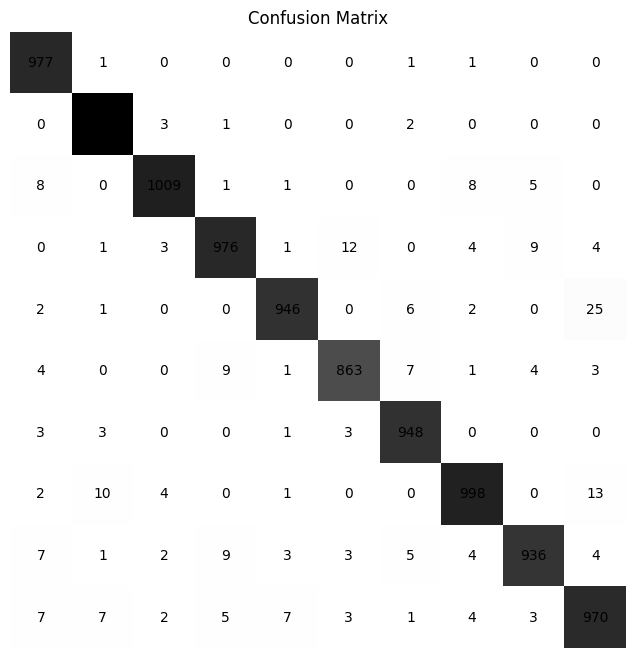

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
knn = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True)
knn.fit(X_train, Y_train)

y_pred = knn.predict(X_test)


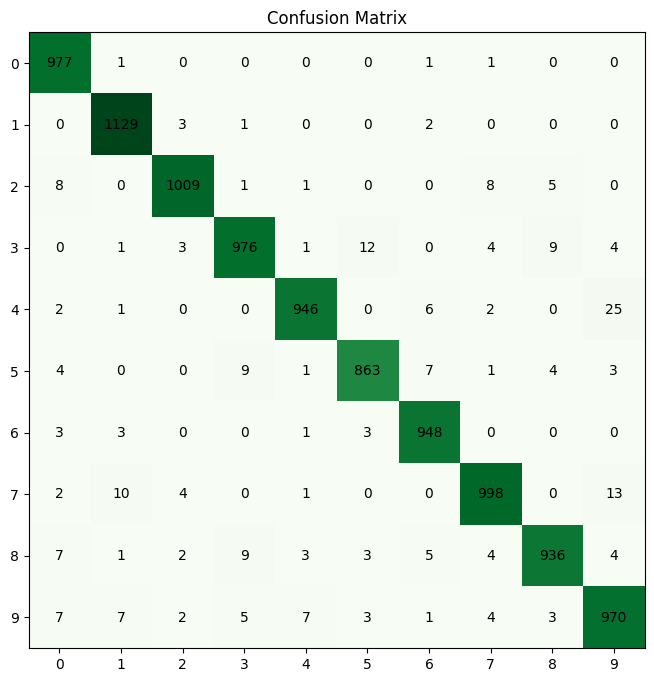

In [ ]:
conf_matrix = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(8, 8))
plt.subplot(1, 1, 1)
plt.imshow(conf_matrix, cmap="Greys", interpolation="nearest")
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="black")
plt.xticks(np.arange(10), labels=np.arange(10))
plt.yticks(np.arange(10), labels=np.arange(10))
plt.title("Confusion Matrix")
plt.show()

In [ ]:
plt.savefig('my_plot.png')  # Сохраните в нужном вам формате

<Figure size 640x480 with 0 Axes>